# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to solve a differential equation

## Imports

In [14]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


from squlearn import Executor
from squlearn.encoding_circuit import (
    KyriienkoEncodingCircuit,
)
from squlearn.encoding_circuit.layered_encoding_circuit import Layer
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, ODELoss
from squlearn.qnn.util import get_lr_decay
from squlearn.optimizers import Adam
from scipy.integrate import odeint

We will use the Pennylane quantum framework for executing the circuits.

In [15]:
executor = Executor("pennylane", shots=None)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC), that implements $\ket{f_{\bm{\theta}, \phi}(x)} = U_{\bm{\theta}} U_{\phi}(x) \ket{0}$.

  $U_{\phi}(x)$ encodes the ODE information and $U_{\bm{\theta}}$ manipulates the function space.

In [16]:
nqubits = 2

circuit = KyriienkoEncodingCircuit(
    num_qubits=nqubits,
    encoding_style="chebyshev_tower",
    variational_arrangement="HEA",
    num_features=1,
    num_encoding_layers=1,
    num_variational_layers=2,
)

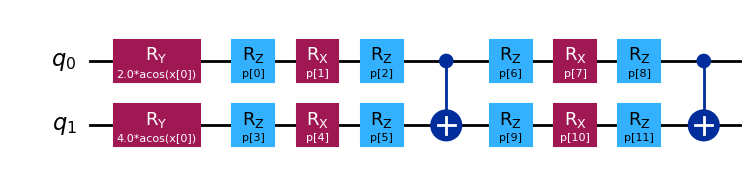

In [17]:
circuit.draw("mpl")

We also need an observable

In [18]:
observable = SummedPaulis(nqubits, include_identity=True)
print(observable)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2])])



We create the homogeneous differential equation to be solved using a sympy symbolic expression


In [19]:
x, f, dfdx, dfdxdx = sp.symbols("x f dfdx dfdxdx")
eq = sp.sin(x) + dfdx + x
initial_values = [1]
eq

dfdx + x + sin(x)

Now we need to create an instance of `ODELoss`, the symbols involved in the ODE must be provided in the correct order: independent variable, function, and higher orders

In [20]:
loss_ODE_sp = ODELoss(
    eq,
    symbols_involved_in_ODE=[x, f, dfdx],
    initial_values=initial_values,
    boundary_handling="pinned",
)

Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `loss_ODE` and `Adam` as the loss function and optimizer respectively. 

In [21]:
# Instead of using random initialization,
param_obs = observable.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)

In [22]:
adam = Adam(options={"maxiter": 100, "tol": 0.009, "lr": get_lr_decay(0.05, 0.02, 125)})

ode_regressor = QNNRegressor(
    circuit,
    observable,
    executor,
    loss_ODE_sp,
    adam,
    param_ini,
    param_obs,
    opt_param_op=True,
)

## Training

Now we are ready to train the model to solve the differential equation

In [23]:
x_space = np.linspace(0, 0.9, 10).reshape(-1, 1)
ref_values = np.zeros(len(x_space))
ode_regressor.fit(x_space, ref_values)

fit: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


## Evaluation

Let's check the trained parameters of the PQC and operator

In [24]:
print("Result PQC params:", ode_regressor.param)
print("Result operator params:", ode_regressor.param_op)

Result PQC params: [-0.37747379  2.74944456 -6.04265745 -1.56739194 -5.06772822 -3.91584745
 -3.70347988 -1.06859569 -1.29725815  1.04921811 -1.64389392  2.32753688]
Result operator params: [0.55502918 1.0042053  0.31177043]


Also let's plot the predicted function vs. the analytical solution

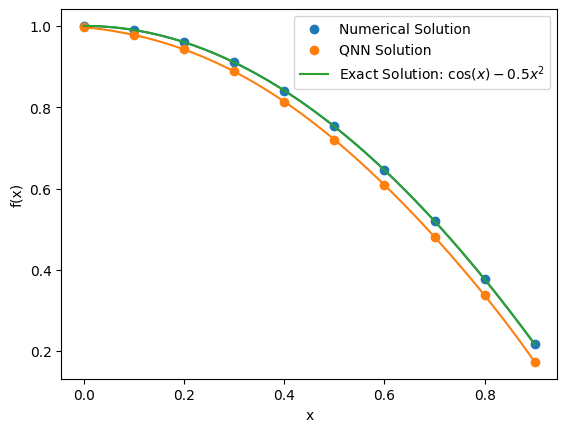

In [25]:
# Numerical solution
y_numerical = odeint(lambda f, x: -np.sin(x) - x, initial_values, x_space.flatten())[:, 0]
plt.scatter(x_space, y_numerical, label="Numerical Solution")
# QNN solution
plt.scatter(x_space, ode_regressor.predict(x_space), label="QNN Solution")

# continuous domain
x_span = np.linspace(0, 0.9, 100).reshape(-1, 1)
y_numerical_cont = odeint(lambda f, x: -np.sin(x) - x, initial_values, x_span.flatten())[:, 0]
plt.plot(x_span, y_numerical_cont)
# QNN solution
plt.plot(x_span, ode_regressor.predict(x_span))
# exact solution
plt.plot(x_span, np.cos(x_span) - 0.5 * x_span**2, label=r"Exact Solution: $\cos(x) - 0.5x^2$")


plt.ylabel("f(x)")
plt.xlabel("x")

plt.legend()